## Preprocessing of police district data

### Preprocessing steps for ALL police districts:
#### 1. Process road network
1. Import polygons of the relevant counties/municipalities
2. Subtract polygons of the municipalities that are not part of the police district
3. Import OSMnx road network from the resulting polygon
4. Impute edge speeds and travel times -> save as GraphML
5. Compute node centrality -> save as CSV


#### 2. Process population data
1. Subtract polygons of the municipalities that are not part of the police district
2. Import and clip population data to the resulting polygon
3. Save population data as GeoJSON

#### 3. Additional notes
- Beware of some districts might need to include roads from neighboring districts for realistic travel times

#### General notes:
- Save and Load all data in the default CRS: WGS84 (EPSG:4326)
- Transform data to correct UTM zone when needed for analysis. UTM zone 33N (EPSG:32633)

In [1]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-17T18:08:35.459791+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from shapely.ops import nearest_points, unary_union
import pyproj
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import igraph as ig
import pulp
import utilityModule

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

shapely   : 2.0.3
pulp      : 2.8.0
osmnx     : 1.9.1
geopandas : 0.14.3
networkx  : 3.2.1
pandana   : 0.7
pyproj    : 3.6.1
pandas    : 2.2.1
matplotlib: 3.8.3
numpy     : 1.26.4
igraph    : 0.11.4



### 1. Process road network - Oslo police district

Preprocessing steps for this district:
1. Import polygons of municipalities: Oslo, Asker, Bærum. (don't need to include roads from neighboring districts)
3. Import OSMnx road network from the resulting polygon
4. Impute edge speeds and travel times
5. Compute node centrality -> save as CSV
6. Save the network to a file -> save as GraphML

In [3]:
### Import road network graph from OpenStreetMap

# 1) Read from local path
# asker_filepath = "../data/askerDriveImputed.graphml" # with travel time attribute
# asker_graph = ox.load_graphml(asker_filepath) # originally in WGS84 (EPSG:4326)

# 2) Fetch from OSM - using OSMnx 
# asker_graph = ox.graph_from_place('asker, Norway', network_type="drive") # originally in WGS84 (EPSG:4326)

In [4]:
# Step 1. Import polygons of asker and Østfold counties

# Fetch individual geodataframes for each municipality
asker_gdf = ox.geocode_to_gdf("Asker, Norway")
barum_gdf = ox.geocode_to_gdf("Bærum, Norway")
oslo_gdf = ox.geocode_to_gdf("Oslo, Norway")

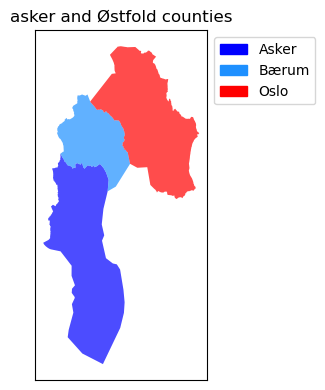

In [5]:
# Concatenate the geodataframes
counties_gdf = pd.concat([asker_gdf, barum_gdf, oslo_gdf], axis=0)

# Plot the counties
# Set the figure size
fig, ax = plt.subplots(figsize=(3, 4))  # Adjust the size values as needed
colors = ['blue', 'dodgerblue', 'red', 'brown', 'chocolate', 'orange']
counties_gdf.plot(ax=ax, color=colors, alpha=0.7)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

legend_labels = ['Asker', 'Bærum', 'Oslo']
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]
ax.legend(handles=patches, loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 10})
plt.title('asker and Østfold counties')
plt.tight_layout()
plt.show()

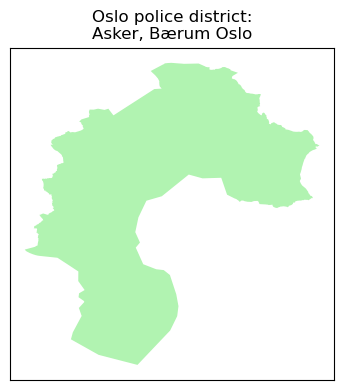

In [6]:
# Step 2. Combine the polygons

# combine the 3 municipality polygons of Asker, Bærum and Oslo
combined_poly = unary_union([asker_gdf.iloc[0].geometry, barum_gdf.iloc[0].geometry, oslo_gdf.iloc[0].geometry])

# # subtract the polygons of Asker, Bærum, Jevnaker and Lunner from the combined polygon
# for gdf in [asker_gdf, barum_gdf, jevnaker_gdf, lunner_gdf]:
#     combined_poly = combined_poly.difference(gdf.iloc[0].geometry)

# plot the resulting polygon
fig, ax = plt.subplots(figsize=(4,4))  # Adjust the size values as needed
gpd.GeoSeries(combined_poly).plot(ax=ax, color='lightgreen', alpha=0.7)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Oslo police district:\nAsker, Bærum Oslo')
plt.tight_layout(); plt.show()

Now we have the correct polygon for the police district. Note that this polygon does not have any coordinate system (CRS) info, we have to add this.   
For GeoDataFrames, we simply use the `to_crs` method, while for shapely polygons we use the `pyproj` library.

In [7]:
# Step 3. Import OSMnx road network from the resulting polygon
oslo_graph = ox.graph_from_polygon(combined_poly, network_type="drive", simplify=True, retain_all=False, truncate_by_edge=False, custom_filter=None)

type:  <class 'networkx.classes.multidigraph.MultiDiGraph'>
crs:   epsg:4326


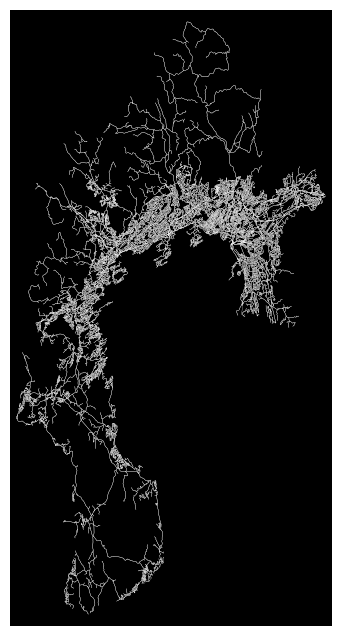

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
print("type: ", type(oslo_graph))
print("crs:  ", oslo_graph.graph['crs'])

# Plot the road network
ox.plot_graph(oslo_graph, node_size=0, edge_color="w", edge_linewidth=0.2, bgcolor="k")

In [9]:
# Convert the graph to node and edge GeoPandas GeoDataFrames
oslo_gdf_nodes, oslo_gdf_edges = ox.graph_to_gdfs(oslo_graph)
print(f"type of oslo_gdf_nodes:{type(oslo_gdf_nodes)}")
oslo_gdf_edges.head(2)

type of oslo_gdf_nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid          name      highway  oneway reversed  length  \
u   v      key                                                                
110 115    0    5121777  Bråtenalléen  residential   False    False 243.278   
    277510 0    5121777  Bråtenalléen  residential   False     True 151.771   

                                                         geometry maxspeed  \
u   v      key                                                               
110 115    0    LINESTRING (10.78341 59.94991, 10.78335 59.949...      NaN   
    277510 0    LINESTRING (10.78341 59.94991, 10.78354 59.949...      NaN   

               lanes  ref bridge tunnel access width junction area est_width  \
u   v      key                                                                 
110 115    0     NaN  NaN    NaN    NaN    NaN   NaN      NaN  NaN       NaN   
    277510 0     NaN  NaN    NaN    NaN    NaN   NaN      NaN  NaN       NaN   

               service  
u   v      key          
110 115    0       NaN  
    277510 0       NaN

#### Inspect OSM edge weights (speed limits) before `osmnx` impute edge speeds



In [10]:
# Select a subset of columns - before imputing edge speeds
subset_columns = ['lanes', 'name', 'highway', 'oneway', 'reversed', 'length', 'maxspeed']
subset_gdf = oslo_gdf_edges[subset_columns]
subset_gdf.head(2)

lanes          name      highway  oneway reversed  length  \
u   v      key                                                             
110 115    0     NaN  Bråtenalléen  residential   False    False 243.278   
    277510 0     NaN  Bråtenalléen  residential   False     True 151.771   

               maxspeed  
u   v      key           
110 115    0        NaN  
    277510 0        NaN

#### Imputing edge speeds and inspecting new columns in resulting GeoDataFrame
The `add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. Imputes free-flow travel speeds for all edges based on mean `maxspeed` value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in `hwy_speeds` and/or `fallback` arguments that correspond to local speed limit standards. See docstring for details.

In [11]:
# impute speed on all edges missing data
oslo_graph = ox.speed.add_edge_speeds(oslo_graph)

# calculate travel time (seconds) for all edges
oslo_graph = ox.speed.add_edge_travel_times(oslo_graph)

# converting graph to node and edge GeoPandas GeoDataFrames
oslo_gdf_nodes, oslo_gdf_edges = ox.graph_to_gdfs(oslo_graph)
print(f"type of oslo_gdf_nodes:{type(oslo_gdf_nodes)}")
print(oslo_gdf_edges.keys())
oslo_gdf_edges.head(2)

type of oslo_gdf_nodes:<class 'geopandas.geodataframe.GeoDataFrame'>
Index(['osmid', 'name', 'highway', 'oneway', 'reversed', 'length', 'geometry',
       'speed_kph', 'travel_time', 'maxspeed', 'lanes', 'ref', 'bridge',
       'tunnel', 'access', 'width', 'junction', 'area', 'est_width',
       'service'],
      dtype='object')


osmid          name      highway  oneway reversed  length  \
u   v      key                                                                
110 115    0    5121777  Bråtenalléen  residential   False    False 243.278   
    277510 0    5121777  Bråtenalléen  residential   False     True 151.771   

                                                         geometry  speed_kph  \
u   v      key                                                                 
110 115    0    LINESTRING (10.78341 59.94991, 10.78335 59.949...     32.400   
    277510 0    LINESTRING (10.78341 59.94991, 10.78354 59.949...     32.400   

                travel_time maxspeed lanes  ref bridge tunnel access width  \
u   v      key                                                               
110 115    0         27.000      NaN   NaN  NaN    NaN    NaN    NaN   NaN   
    277510 0         16.900      NaN   NaN  NaN    NaN    NaN    NaN   NaN   

               junction area est_width service  
u   v      key                                  
110 115    0        NaN  NaN       NaN     NaN  
    277510 0        NaN  NaN       NaN     NaN

In [12]:
# Export the graph to a file in GraphML format
ox.save_graphml(oslo_graph, "../data/Oslo/OsloDriveImputed.graphml")

Next is computing the closeness centrality for each node in the network. This is a measure of how central a node is in the network. It is calculated as the reciprocal of the sum of the shortest path distances from the node to all other nodes in the network. The higher the value, the more central the node is.   
Current implementation uses the `networkx` library, which is quite slow and memory intensive for this operation. At least it is only computed once and saved to a CSV file.   
TODO: Implement a faster method for computing centrality.

In [13]:
%%time
# 5. Compute node centrality - using NetworkX (suitable for small graphs)
# Calculate closeness centrality
# oslo_centrality = nx.closeness_centrality(oslo_graph_increased, distance='travel_time')
# oslo_gdf_nodes['closeness_centrality'] = oslo_gdf_nodes.index.map(oslo_centrality)

CPU times: total: 0 ns
Wall time: 0 ns


In [14]:
# 5. Compute node centrality - using igraph (suitable for large graphs)

# converting the networkx graph to an igraph graph
osmids = list(oslo_graph.nodes)
oslo_graph = nx.relabel.convert_node_labels_to_integers(oslo_graph)

# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(oslo_graph.nodes, osmids)}
nx.set_node_attributes(oslo_graph, osmid_values, "osmid")

In [15]:
%%time
# convert networkx graph to igraph
oslo_igraph= ig.Graph(directed=True)
oslo_igraph.add_vertices(oslo_graph.nodes)
oslo_igraph.add_edges(oslo_graph.edges())
oslo_igraph.vs["osmid"] = osmids
oslo_igraph.es["travel_time"] = list(nx.get_edge_attributes(oslo_graph, "travel_time").values())

CPU times: total: 62.5 ms
Wall time: 88.1 ms


In [16]:
assert len(oslo_graph.nodes()) == oslo_igraph.vcount()
assert len(oslo_graph.edges()) == oslo_igraph.ecount()

In [17]:
# check for any non-positive travel time values
non_positive_edges = [e for e in oslo_igraph.es if e["travel_time"] <= 0]
print(f"Number of non-positive travel time edges: {len(non_positive_edges)}")

# show the non-positive travel time edges
non_positive_edges[:]

# inspect the non-positive travel time edges, if small we can set them to a small positive value
for e in non_positive_edges:
    print(e.tuple, e["travel_time"])

# Set the non-positive travel time edges to a small positive value
for e in non_positive_edges:
    e["travel_time"] = 1

# Re-check for any non-positive travel time values
non_positive_edges = [e for e in oslo_igraph.es if e["travel_time"] <= 0]
print(f"Number of non-positive travel time edges (2nd time): {len(non_positive_edges)}")

# this returned 6 non-positive travel time edges. This can happen when the travel time is not imputed for some edges.
# We can either remove these edges or impute the travel time for them. Here we added a small positive value to the travel time.

Number of non-positive travel time edges: 9
(5705, 17579) 0.0
(5984, 11424) 0.0
(10381, 13734) 0.0
(13811, 6335) 0.0
(13814, 6334) 0.0
(15413, 12656) 0.0
(16802, 16801) 0.0
(16805, 16804) 0.0
(17579, 5705) 0.0
Number of non-positive travel time edges (2nd time): 0


In [18]:
%%time
# closeness centrality with igraph - incoming and outgoing paths
closeness1 = oslo_igraph.closeness(vertices=None, mode="all", cutoff=None, weights="travel_time", normalized=True)
max_closeness1 = np.argmax(closeness1) # 

CPU times: total: 28.5 s
Wall time: 37.9 s


In [19]:
%%time
# betweenness centrality with igraph
betweenness1 = oslo_igraph.betweenness(vertices=None, directed=True, cutoff=None, weights="travel_time")
max_betweenness1 = np.argmax(betweenness1)

CPU times: total: 39.1 s
Wall time: 45.9 s


In [20]:
# inspect the maximum centrality values
print(f"Max closeness centrality (1st method): {max_closeness1}, {closeness1[max_closeness1]}")
print(f"Max betweenness centrality (1st method): {max_betweenness1}, {betweenness1[max_betweenness1]}")

Max closeness centrality (1st method): 6806, 0.0012460555175418833
Max betweenness centrality (1st method): 16741, 70829455.5


In [21]:
# adding the centrality values to the node GeoDataFrame
oslo_gdf_nodes["closeness_centrality"] = closeness1 # all nodes
oslo_gdf_nodes["betweenness_centrality"] = betweenness1 # all nodes

In [22]:
oslo_gdf_nodes.head(2)

# # sort by betweenness centrality descending
# oslo_gdf_nodes.sort_values(by="betweenness_centrality", ascending=False).head(20)

,y,x,street_count,highway,ref,geometry,closeness_centrality,betweenness_centrality
osmid,,,,,,,,
110,59.950,10.783,4,NaN,NaN,POINT (10.78341 59.94991),0.001,529576.000
111,59.948,10.788,3,NaN,NaN,POINT (10.78753 59.94755),0.001,139905.000


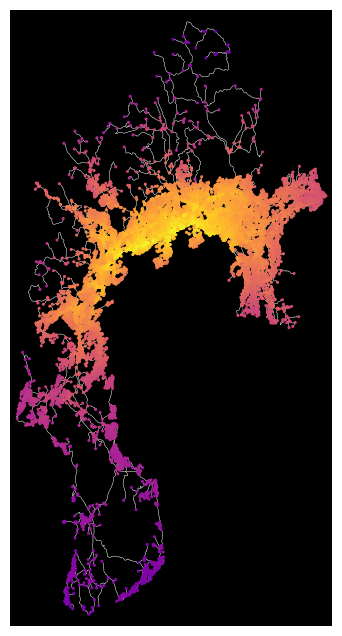

In [23]:
# Plot the road network with the closeness centrality values as node colors - using OSMnx
# node_color
nc = oslo_gdf_nodes["closeness_centrality"]
nc = nc / nc.max()
nc = plt.cm.plasma(nc)

# plot the road network with the closeness centrality values as node colors
fig, ax = ox.plot_graph(oslo_graph, node_size=5, node_color=nc, edge_color="w", edge_linewidth=0.2, bgcolor="k", show=False, close=False)
plt.show()

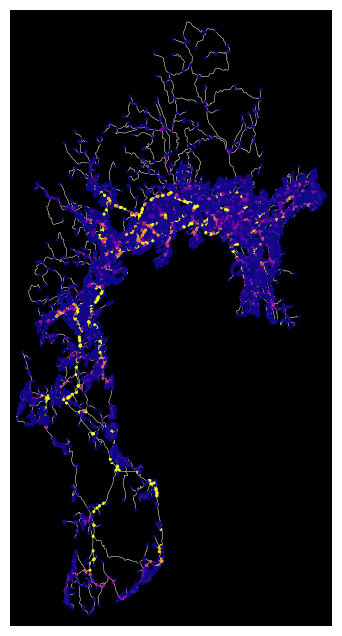

In [24]:
# Plot the road network with the betweenness centrality values as node colors - using OSMnx
# node_color
scale_factor = 10
nc = oslo_gdf_nodes["betweenness_centrality"]
nc = scale_factor * nc / nc.max()
nc = plt.cm.plasma(nc)

# plot the road network with the betweenness centrality values as node colors
fig, ax = ox.plot_graph(oslo_graph, node_size=5, node_color=nc, edge_color="w", edge_linewidth=0.2, bgcolor="k", show=False, close=False)
plt.show()

In [25]:
# Save centrality to CSV file with 'closeness_centrality' column and 'osmid' as index

# Prepare the node GeoDataFrame for saving to CSV file with columns for 'closeness_centrality' and 'betweenness_centrality' and 'osmid' as index
oslo_gdf_nodes_centrality = oslo_gdf_nodes[["closeness_centrality", "betweenness_centrality"]]
oslo_gdf_nodes_centrality.to_csv("../data/Oslo/OsloNodeCentrality.csv", index=True) # recently changed this to True


# Load centrality from CSV file
oslo_gdf_nodes_imported = pd.read_csv("../data/Oslo/OsloNodeCentrality.csv", index_col=0)
oslo_gdf_nodes_imported.head(2)

# print the single highest closeness centrality value
max_closeness = oslo_gdf_nodes_imported["closeness_centrality"].max()
print(f"Max closeness centrality: {max_closeness}")

Max closeness centrality: 0.0012460555175418


In [26]:
oslo_gdf_nodes_imported.head(2)

,closeness_centrality,betweenness_centrality
osmid,,
110,0.001,529576.000
111,0.001,139905.000


The CRS of the road network have remained unchanged as WGS4 (EPSG:4326).   
Conversion to UTM33N (EPSG:32633) is done after importing the network and before any analysis.

### 2. Process population data
1. Import counties/municipalitiy population data for the police district.
2. Import and clip population data to the resulting polygon.
3. Save population data as GeoJSON.

In [27]:
# Step 1. Import counties/municipalitiy population data for the police district
# Load asker and Østfold population data
asker_population_path = "../data/Oslo/ssb_data/asker/v_ru250m_2023_rutenett.geojson"
barum_population_path = "../data/Oslo/ssb_data/barum/v_ru250m_2023_rutenett.geojson"
oslo_population_path = "../data/Oslo/ssb_data/oslo/v_ru250m_2023_rutenett.geojson"
asker_population = gpd.read_file(asker_population_path)
barum_population = gpd.read_file(barum_population_path)
oslo_population = gpd.read_file(oslo_population_path)
asker_population.columns = ['id', 'population', 'geometry'] # rename column names
barum_population.columns = ['id', 'population', 'geometry'] # rename column names
oslo_population.columns = ['id', 'population', 'geometry'] # rename column names

In [28]:
# Step 2. Import and clip population data to the resulting polygon.
# Already have 'combined_poly' from previous steps to clip the population data

# combine the population data for asker, barum and oslo
population_gdf = pd.concat([asker_population, barum_population, oslo_population], axis=0)

# clip the population data to the resulting polygon
clipped_population = gpd.clip(population_gdf, combined_poly)

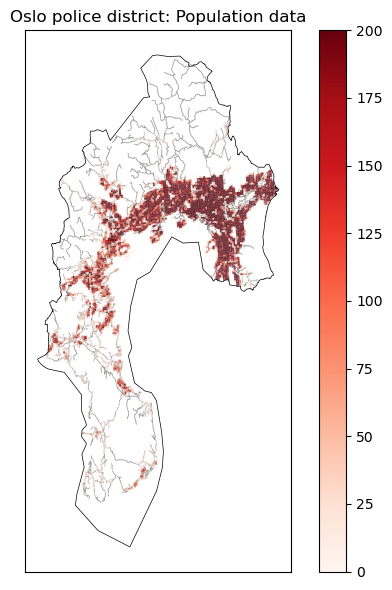

In [29]:
# plot the clipped population data, with the combined polygon as outline and the population colored by population size
fig, ax = plt.subplots(figsize=(6,6))  # Adjust the size values as needed

# plot edges (oslo_graph_increased) in thin gray lines
oslo_graph_increased_edges = ox.graph_to_gdfs(oslo_graph, nodes=False, edges=True)
oslo_graph_increased_edges.plot(ax=ax, linewidth=0.5, edgecolor='gray', alpha=0.5, zorder=-1)

combined_poly_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(combined_poly))
combined_poly_gdf.boundary.plot(ax=ax, color='k', linewidth=0.5)

# set custom range for the color map
vmin, vmax = 0, 200
clipped_population.plot(ax=ax, column='population', cmap='Reds', legend=True, alpha=0.7, vmin=vmin, vmax=vmax)
# clipped_population.plot(ax=ax, column='population', cmap='jet', legend=True, alpha=0.7)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Oslo police district: Population data')
plt.tight_layout(); plt.show()

In [30]:
# Step 3. Save population data as GeoJSON.

# Save the clipped population data to a file
clipped_population.to_file("../data/Oslo/OsloPopulation.geojson", driver="GeoJSON")

# load the population data from the file
clipped_population_imported = gpd.read_file("../data/Oslo/OsloPopulation.geojson")
clipped_population_imported.head(2)

,id,population,geometry
0,22425006607500,7,"POLYGON ((10.44602 59.52643, 10.44572 59.52867..."
1,22425006607750,1,"POLYGON ((10.44572 59.52867, 10.44542 59.53091..."


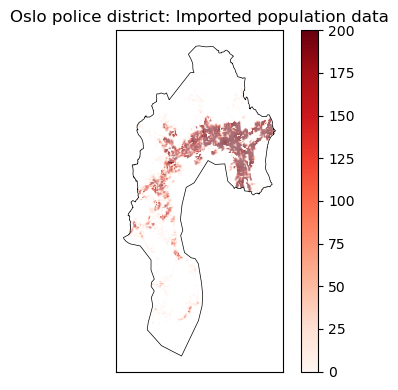

In [31]:
# plot the imported population data for verification
fig, ax = plt.subplots(figsize=(4,4))  # Adjust the size values as needed
combined_poly_gdf.boundary.plot(ax=ax, color='k', linewidth=0.5)
clipped_population_imported.plot(ax=ax, column='population', cmap='Reds', legend=True, alpha=0.7, vmin=vmin, vmax=vmax)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Oslo police district: Imported population data')
plt.tight_layout(); plt.show()

In [32]:
# Also save the combined polygon to a file
combined_poly_gdf.to_file("../data/Oslo/OsloCombinedPolygon.geojson", driver="GeoJSON")

# Load the combined polygon from the file
combined_poly_imported = gpd.read_file("../data/Oslo/OsloCombinedPolygon.geojson")
combined_poly_imported.head(2)

,geometry
0,"POLYGON ((10.54515 59.78833, 10.54210 59.77400..."
